### Imports & Google Colab Management

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import *
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Pre-Processing

This was done locally (not on Google Colab) due to memory issues. The respective code was copied here for the purpose of completeness.


```
import cv2
import numpy as np
import torch
import os
from tqdm import tqdm
import re
```





```
label_dict = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

for dataset in ['train', 'test']:

    X = []
    y = []

    for label in tqdm(label_dict):
        img_files = os.listdir(os.path.join('Intel_images', dataset, label))
        img_files.sort(key=lambda f: int(re.sub('\D', '', f)))
        for img in img_files:
            RGB_img = cv2.imread(os.path.join('Intel_images', dataset, label, img), cv2.COLOR_BGR2RGB)
            if RGB_img.shape != (150,150,3):
                pass
            else:
                X.append(RGB_img)
                y.append(label_dict[label])

    X = np.array(X)
    y = np.array(y)

    torch.save(X, 'X_' + dataset + '.pt')
    torch.save(y, 'y_' + dataset + '.pt')
```



### Load Dataset

In [3]:
# Load train data

X = torch.load("path/to/your/data/X_train.pt")
print(X.shape)

y = torch.load('path/to/your/data/y_train.pt')
print(y.shape)

(13986, 150, 150, 3)
(13986,)


In [4]:
# Load test data

X_test = torch.load("path/to/your/data/X_test.pt")
print(X_test.shape)

y_test = torch.load('path/to/your/data/y_test.pt')
print(y_test.shape)

(2993, 150, 150, 3)
(2993,)


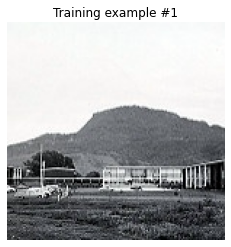

In [5]:
# visualize sample images

sample = 1
plt.imshow(X[sample-1])
plt.title(f"Training example #{sample}")
plt.axis('off')
plt.show()

### Create Dataloaders

In [6]:
# define train dataset class

class TrainDataset(Dataset):
    def __init__(self, X, y):
          'Initialization'
          self.X = X
          self.y = y
          self.transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773]),
              transforms.Resize(224),
              transforms.RandomHorizontalFlip(p=0.5),
              ])

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        image = self.X[index]
        X = self.transform(image)
        y = self.y[index]
        return X, y

In [7]:
# define test dataset class

class TestDataset(Dataset):
    def __init__(self, X):
          'Initialization'
          self.X = X
          self.transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([115.70155906, 116.65272372, 109.69618953], [76.06980096, 68.32058804, 68.69814773]),
              transforms.Resize(224)              
              ])

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'
        image = self.X[index]
        X = self.transform(image)
        return X

In [8]:
# create dataloaders

batch_size = 128

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)

train_dataset = TrainDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, batch_size, num_workers=2, shuffle=True)

val_dataset = TrainDataset(X_val, y_val)
val_dl = DataLoader(val_dataset, batch_size, num_workers=2, shuffle=True)

test_dataset = TestDataset(X_test)
test_dl = DataLoader(test_dataset, batch_size, num_workers=2, shuffle=False)

### Training Functions


In [9]:
# predict labels

def predict_labels(net, test_dl):
    
    all_predictions = []
    for test_data in test_dl:  
        test_data = torch.Tensor(test_data).to(device, dtype=torch.float)
        output = net(test_data)
        _,predictions = torch.max(output, dim=1)
        predictions = list(predictions.cpu().numpy())
        all_predictions.extend(predictions)

    return all_predictions


In [10]:
# Write predictions for every epoch to csv file

def write_predictions(epoch, predictions):

    if epoch == 1: 
        instance_flow = pd.DataFrame()
    else:
        instance_flow = pd.read_csv("path/to/your/data/predictions.csv")
    predictions = pd.Series(predictions)
    instance_flow[str(epoch)] = predictions
    instance_flow.to_csv("path/to/your/data/predictions.csv", index=False)


In [11]:
# train function

def train(net, criterion, optimizer, scheduler, n_epochs):

    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    valid_loss_min = np.Inf
    total_step = len(train_dl)
    
    for epoch in range(1, n_epochs+1):
        
        running_loss = 0
        correct = 0
        total=0

        print(f'Epoch {epoch}\n')

        for batch_idx, (data, targets) in enumerate(train_dl):

            data, targets = torch.Tensor(data).to(device, dtype=torch.float), torch.Tensor(targets).to(device,  dtype=torch.int64)
            optimizer.zero_grad()
            outputs = net(data)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,predictions = torch.max(outputs, dim=1)
            correct += torch.sum(predictions==targets).item()
            total += targets.size(0)

            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        
        batch_loss = 0
        total_v=0
        correct_v=0

        with torch.no_grad():
            net.eval()

            for data_v, targets_v in val_dl:
                data_v, targets_v = torch.Tensor(data_v).to(device, dtype=torch.float), torch.Tensor(targets_v).to(device, dtype=torch.int64)
                outputs_v = net(data_v)
                loss_v = criterion(outputs_v, targets_v)
                batch_loss += loss_v.item()
                _,predictions_v = torch.max(outputs_v, dim=1)
                correct_v += torch.sum(predictions_v==targets_v).item()
                total_v += targets_v.size(0)
          
            val_acc.append(100 * correct_v/total_v)
            val_loss.append(batch_loss/len(val_dl))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_v/total_v):.4f}\n')

            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), 'path/to/your/model/landscape_resnet.pt')
                print('Improvement detected, saved model')

            test_predictions = predict_labels(net, test_dl)
            write_predictions(epoch, test_predictions)
        
        scheduler.step(batch_loss)
        net.train()

    return train_loss, train_acc, val_loss, val_acc

### Train Resnet50-Model

In [12]:
# initialize pretrained resnet-50 model or load model to refine

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
refine = False

net = models.resnet50(pretrained=True)
net = net.to(device)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 6)
net.fc = net.fc.to(device)

if refine:
    net.load_state_dict(torch.load('path/to/your/model/landscape_resnet.pt'))

print(net)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# train model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')

n_epochs = 50

train_loss, train_acc, val_loss, val_acc = train(net, criterion, optimizer, scheduler, n_epochs)

Epoch 1

Epoch [1/50], Step [0/99], Loss: 1.7919
Epoch [1/50], Step [20/99], Loss: 1.7277
Epoch [1/50], Step [40/99], Loss: 1.6199
Epoch [1/50], Step [60/99], Loss: 1.5337
Epoch [1/50], Step [80/99], Loss: 1.4318

train-loss: 1.5787, train-acc: 46.0634
validation loss: 1.6916, validation acc: 20.4432

Improvement detected, saved model
Epoch 2

Epoch [2/50], Step [0/99], Loss: 1.3726
Epoch [2/50], Step [20/99], Loss: 1.2385
Epoch [2/50], Step [40/99], Loss: 1.2066
Epoch [2/50], Step [60/99], Loss: 1.0435
Epoch [2/50], Step [80/99], Loss: 1.0068

train-loss: 1.3574, train-acc: 68.5231
validation loss: 1.7959, validation acc: 15.6540

Epoch 3

Epoch [3/50], Step [0/99], Loss: 0.9465
Epoch [3/50], Step [20/99], Loss: 0.9448
Epoch [3/50], Step [40/99], Loss: 0.8701
Epoch [3/50], Step [60/99], Loss: 0.9051
Epoch [3/50], Step [80/99], Loss: 0.7844

train-loss: 1.1962, train-acc: 76.0944
validation loss: 1.7976, validation acc: 15.6540

Epoch 4

Epoch [4/50], Step [0/99], Loss: 0.7740
Epoch [4

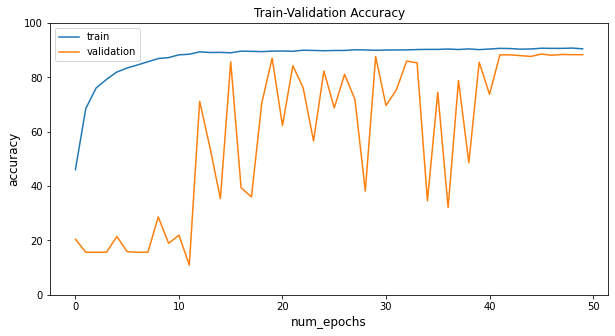

In [16]:
# plot train and validations accuracy

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.ylim([0, 100])
plt.legend(loc='best')

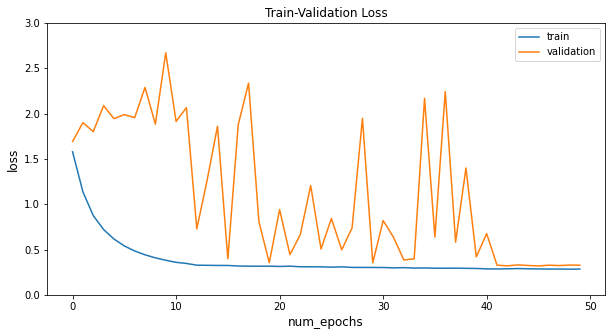

In [18]:
# plot train and validation loss

fig = plt.figure(figsize=(10,5))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.ylim([0, 3])
plt.legend(loc='best')

In [20]:
torch.save(train_acc, 'path/to/your/data/train_accuracy.pt')
torch.save(train_acc, 'path/to/your/data/validation_accuracy.pt')

torch.save(train_loss, 'path/to/your/data/train_loss.pt')
torch.save(val_loss, 'path/to/your/data/validation_loss.pt')